1 - README.md

In [1]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

# 2 - Load Data

**WORK WITH TIME-SERIES DATA:**

Data preprocessing methodology:

- When working with time-series data such as Bitcoin prediction problem, it is recommended to set `shuffle=False` when splitting data into train-test. (This is because if `shuffle=True`, we may end up predicting past Bitcoin prices). <br>
For other prediction problems such as house prices or car prices, it is appropriate to set `shuffle=True` (because if `shuffle=False`, for example, the house price data is sorted by price, then there is a risk of falling into the case where all houses put into the test set have higher/lower values than the average and this will result in a poor model).

- This data is time series it's sequential, so we don't use Cross-Validation or any of the model ML techniques to evaluate error. TimeSeriesSplit, which is a specific type of cross-validation technique used for time series data. It's important to use time-series cross-validation when dealing with sequential data to avoid training on future data. TimeSeriesSplit splits the data into folds, so that the folds with data from the previous past will be used as the training set, and the future data will only be used as the test set. For example, if we split the data into 3 folds, each fold would consist of:
    - Fold 1: Data from January 2016 to December 2017 (training set) and data from January 2018 to December 2018 (test set).    
    - Fold 2: Data from January 2016 to December 2018 (training set) and data from January 2019 to December 2019 (test set).    
    - Fold 3: Data from January 2016 to December 2019 (training set) and data from January 2020 to December 2020 (test set). <br>

The code: `tscv = TimeSeriesSplit(n_splits=3)` will creat a time-series cross-validation object that splits the data into 3 folds in chronological order.

- It's convenient: to have data ORDERED IN INCREASING ORDER OF DATE(with Time-Series Data)

In [3]:
# Load Data
import pandas as pd
# data = pd.read_csv("https://github.com/lavibula/GoldPricePrediction/blob/main/data/data_preparation/data_preparation.csv")
# data = pd.read_csv("https://raw.githubusercontent.com/lavibula/GoldPricePrediction/main/data/data_preparation/data_preparation.csv")
data = pd.read_csv("D:/OneDrive - Hanoi University of Science and Technology/GIT/MiniProj_StockPrediction_ML_SpManhGraduationProj_2024/data/raw20192024/FPT_stock_data.csv")
# data = data.sort_values('Date', ascending=True).reset_index(drop=True) # drop=True bỏ 'index' col cũ.

print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1477 non-null   object 
 1   open    1477 non-null   float64
 2   high    1477 non-null   float64
 3   low     1477 non-null   float64
 4   close   1477 non-null   float64
 5   volume  1477 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 69.4+ KB
None


,time,open,high,low,close,volume
0,2019-01-02,15580.0,15710.0,15330.0,15350.0,459120
1,2019-01-03,15450.0,15450.0,15170.0,15200.0,716600
2,2019-01-04,15130.0,15450.0,15090.0,15320.0,318570
3,2019-01-07,15580.0,15690.0,15500.0,15580.0,408470
4,2019-01-08,15580.0,15650.0,15540.0,15650.0,295660
...,...,...,...,...,...,...
1472,2024-11-22,132900.0,134400.0,132500.0,133900.0,2915900
1473,2024-11-25,134000.0,134000.0,133200.0,133900.0,1849700
1474,2024-11-26,133400.0,135900.0,133300.0,135200.0,4176100
1475,2024-11-27,135200.0,139700.0,135200.0,138900.0,9814300


In [4]:
# Use BTC_close_tomorrow -> y (Target col) of X_today, BTC_close_today -> 1 feature in X_today.
data["close_tomor"] = data["close"].shift(-1)
data = data.iloc[:-1] # data = data.drop(data.index[-1]) # Xóa hàng cuối
data.drop('close', axis=1, inplace=True) # axis=1 xóa cột, =0 xóa hàng, inplace thay đổi trực tiếp trên df hiện tại
data  # 3422 rows × 18 columns -> 17 col

C:\Users\User\AppData\Local\Temp\ipykernel_41864\519355196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('close', axis=1, inplace=True) # axis=1 xóa cột, =0 xóa hàng, inplace thay đổi trực tiếp trên df hiện tại


,time,open,high,low,volume,close_tomor
0,2019-01-02,15580.0,15710.0,15330.0,459120,15200.0
1,2019-01-03,15450.0,15450.0,15170.0,716600,15320.0
2,2019-01-04,15130.0,15450.0,15090.0,318570,15580.0
3,2019-01-07,15580.0,15690.0,15500.0,408470,15650.0
4,2019-01-08,15580.0,15650.0,15540.0,295660,15800.0
...,...,...,...,...,...,...
1471,2024-11-21,132400.0,133000.0,131000.0,3176700,133900.0
1472,2024-11-22,132900.0,134400.0,132500.0,2915900,133900.0
1473,2024-11-25,134000.0,134000.0,133200.0,1849700,135200.0
1474,2024-11-26,133400.0,135900.0,133300.0,4176100,138900.0


# 3 - Train Model use Multi Linear Regression

## 3.0 Định nghĩa và Đóng gói def cal metric and draw plot

1. Difinition
- Linear Regression methodology:
    - Simple Linear Regression: only 1 independent var Y = b0 + b1*X
    - Multi Linear Regression: More than one independent variable   
    Y = m0 + m1X1 + m2X2 + m3X3 + ... + mNXN
    - Polynomial Regression: independent variable of higher order than 1 (for example, order 2, 3)
- Logistic Reg: Classification Problem. (probability prediction of dependent variable based on independent variables.)

2. How Model works:
- In Linear Regression, we need to find the parameter set m_i (i from 0 to N) so that the function Y = f(X) best fits the training data set.

- The process of finding the model parameter: w0, w1, ..., wn set through the training process can use Gradient Descent, Stochastic Gradient Descent or Normal Equation methods by optimizing the MSE loss function.

MSE (Mean Squared Error) loss function formula```MSE = 1/n * (Yi - Ŷi)^2```
In there:
- Yi is the actual output value of the i-th data point;
- Ŷi is the output value predicted by the model with input Xi;
- n is the number of data points in the training set.

In [5]:
# Đóng gói def Evaluate_Model and def Plot_Model
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test):
  """
  parameters: `y_test`, `y_pred_test`
  calculates evaluation metrics,
    including R-squared, MSE, RMSE, MAE, MAPE,
      and directional accuracy (DA)
  """
# Đóng gói def Evaluate_Model and def Plot_Model
  print('EVALUATE METRICS ON THE TRAIN SET')
  print('Coefficient of determination R2:', r2_score(y_train, y_pred_train)) # print(model.score(X_test, y_train))
  print('Mean Squared Error MSE:', mean_squared_error(y_train, y_pred_train))
  print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
  print('Mean Absolute Error MAE:', mean_absolute_error(y_train, y_pred_train))
  MAPE = mean_absolute_percentage_error(y_train, y_pred_train)
  # MAPE = np.mean(np.abs((np.array(y_train) - np.array(y_pred_train)) / y_train))
  print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 4)}%", '\n')

  print('EVALUATE METRICS ON THE TEST SET')
  print('Coefficient of determination R2:', r2_score(y_test, y_pred_test)) # print(model.score(X_test, y_test))
  print('Mean Squared Error MSE:', mean_squared_error(y_test, y_pred_test))
  print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
  print('Mean Absolute Error MAE:', mean_absolute_error(y_test, y_pred_test))
  MAPE = mean_absolute_percentage_error(y_test, y_pred_test)
  # MAPE = np.mean(np.abs((np.array(y_test) - np.array(y_pred_test)) / y_test))
  print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 4)}%")

def Plot_Model(y_test, y_pred_test, num_samples):
  """
  Scatter Plot(Biểu đồ phân tán) with x_axis: y_test, y_axis: y_pred_test
  Print test_pred_df
  Line Plot with x_axis: position point, y_axis: Value and 2 line: y_test, y_pred_test
  """
  # Gộp 2 Plot scatterplot and lineplot
  plt.subplots(figsize=(15,7)) # return tuple (Figure, Axes). obj Figure: toàn bộ hình ảnh, obj Axes: các vùng trực quan.
  ax1 = plt.subplot(121)
  ax2 = plt.subplot(122)

  # Scatter plot
  ax1.scatter(y_test, y_pred_test)
  ax1.set_title("Predictions vs Actual")  #plt.title
  ax1.set_xlabel("y_true")                #plt.xlabel
  ax1.set_ylabel("y_pred_test")           #plt.ylabel

  x = range(int(max(y_test))) #vẽ đường chéo giữa.
                              # type y_test from df: <class 'pandas.core.series.Series'>, tương tự df, but have only 1 col
  ax1.plot(x, 'r') # Opt speed, we can use x = np.arange(int(max(y_test))).astype(int)

  # Line plot with x_axis: position point, y_axis: Value and 2 line: y_test, y_pred_test
  #1 plot vẽ tập Test nhưng show ra x 6000 điểm -> vì plot ra index của hàng ban đầu.
  #2 Muốn plot ra tập sample với ít điểm giá trị hơn.
  #3 Muốn plot hiện điểm 1, 2, 3, ... chứ không phải điểm 0.0, 0.5, 1.0, ...
  test_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test}) # Create df 3 col: index, y_test, y_pred_test
  test_pred_subset_df = pd.DataFrame({'y_test_few': y_test[:num_samples], 'y_pred_test_few': y_pred_test[:num_samples]}) #2
  test_pred_subset_df = test_pred_subset_df.reset_index(drop=True) #1 Add a reset index and Remove old index

  # sns.lineplot(data=test_pred_subset_df) # data = df
  sns.lineplot(data=test_pred_subset_df).set(xticks=range(0, num_samples+1, int(num_samples/5)+1))
                                        # set x_axis ticks (dấu kiểm) hiện ít điểm hơn trên x
  ax2.set_title("Test Predictions")
  ax2.set_xlabel("Point") # tên hàng
  ax2.set_ylabel("Value")
  plt.show() # show những plots above

# y_train = [10 , 15, 20, 25, 30, 35, 40]
# y_pred_train = [-10, -15, -20, -25, -30, -35, -40]

# y_test = [10 , 15, 20, 25, 30, 35, 40]
# y_pred_test = [-10, -15, -20, -25, -30, -35, -40]
# Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test)
# Plot_Model(y_test, y_pred_test, 6)

Split Data

In [7]:
# Split data for pre-train
X = data.drop(['close_tomor', 'time'], axis=1)
y = data['close_tomor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle = False) # shuffle: default: True, False sẽ giúp dùn qk để train và dự báo cho tương lai.


In [9]:
print(len(X_train), len(X_test))

1107 369


## 3.1 Linear Reg Model use Hold-out split data

EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9977845563718858
Mean Squared Error MSE: 673006.0311099022
Root Mean Squared Error RMSE: 820.3694479378801
Mean Absolute Error MAE: 518.1355345287592
Mean Absolute Percentage Error MAPE% 1.2844% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.995382013661036
Mean Squared Error MSE: 2937059.0575400577
Root Mean Squared Error RMSE: 1713.785009136227
Mean Absolute Error MAE: 1254.468670758624
Mean Absolute Percentage Error MAPE% 1.226%


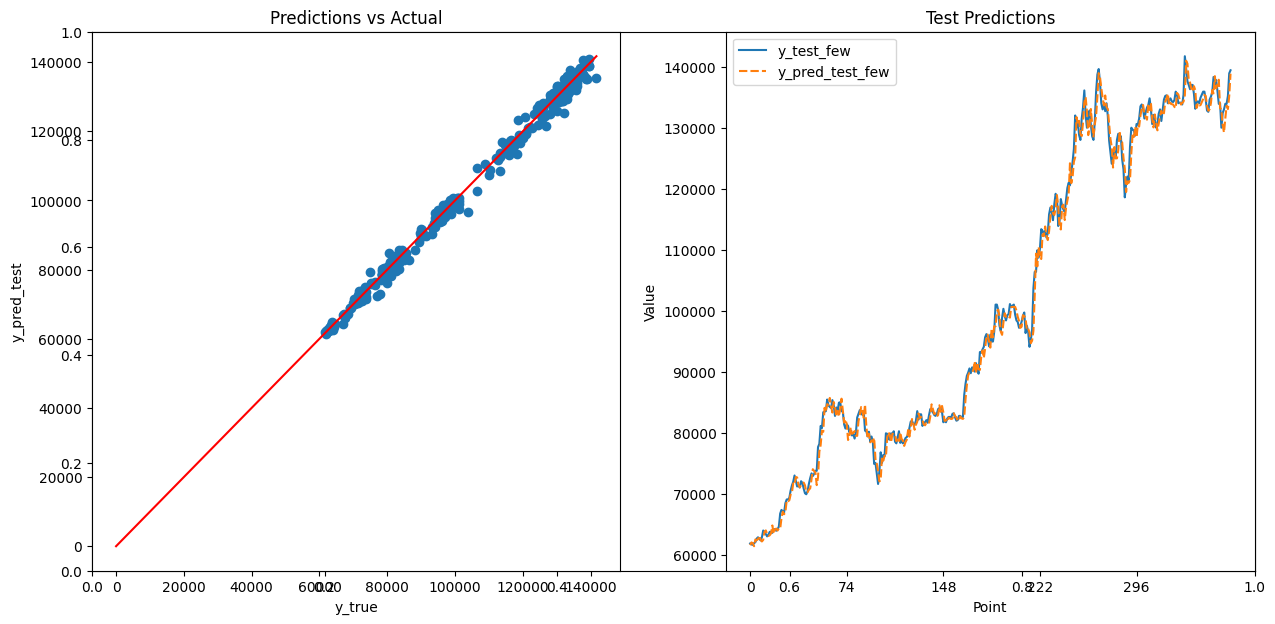

In [10]:
# Hold-out split data train baselin Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

reg_model = LinearRegression()   # shuffle: default: True, False sẽ giúp dùn qk để train và dự báo cho tương lai.
reg_model.fit(X_train,y_train)

y_pred_train = reg_model.predict(X_train)
y_pred_test = reg_model.predict(X_test)

Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test)
Plot_Model(y_test, y_pred_test, len(y_test))

## 3.2 Lasso and Ridge reg

### Methodlodogy


1. Definition:
- Lasso and Ridge Regression are two regularization methods used to reduce overfitting in Linear Regression model.    
    - Lasso uses L1 regularization: to remove unimportant variables completely BY push the coefficients to zero completely.
    - Ridge uses L2 regularization: to remove unimportant variables incompletely BY push the coefficients close to zero, but never down to zero completely.    
- The choice between these two methods depends on THE NUMBER OF FEATURES AND INFLUENCE OF EACH FEATURE.

2. How model work? similar to Linear Regression with loss function.

And the formula for Lasso Regression loss function is:

$$MSE_{Lasso} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 + \alpha \sum_{j=1}^{p} |w_j|$$

The formula for Ridge Regression loss function is:

$$MSE_{Ridge} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 + \alpha \sum_{j=1}^{p} w_j^2$$



- $MSE$ is the mean squared error between the predicted values and the true values.
- $n$ is the number of training samples.
- $p$ is the number of features in the model.
- $y_i$ is the true value of the ith sample.
- $\hat{y_i}$ is the predicted value of the ith sample.
- $w_j$ is the weight corresponding to the jth feature in the model.
- $\alpha$ is the regularization parameter.

### Khởi đầu với Simple Ridge Regression -> Tiến tới đóng gói để train Ridge Regression and Lasso Regression

In [11]:
# SIMPLE Ridge Regression when hyperparameters have not been adjusted
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha = 0.5, solver='lsqr') # lsqr: tối ưu
ridge_model.fit(X_train, y_train)

y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_test_ridge = ridge_model.predict(X_test)

Evaluate_Model(y_train, y_pred_train_ridge, y_test, y_pred_test_ridge)

EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9977797155743999
Mean Squared Error MSE: 674476.5654363135
Root Mean Squared Error RMSE: 821.2652223467845
Mean Absolute Error MAE: 518.185109464765
Mean Absolute Percentage Error MAPE% 1.2845% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.995302257226857
Mean Squared Error MSE: 2987784.490706912
Root Mean Squared Error RMSE: 1728.5208968094403
Mean Absolute Error MAE: 1267.4393457168815
Mean Absolute Percentage Error MAPE% 1.2371%


Find best parameters Ridge Reg

### Packaging the LinearRegressionModel Class for hyperparameters tuning in Ridge and Lasso Regression

Methodology:
Grid Search (tìm kiếm theo lưới) and randomized search (tìm kiếm ngẫu nhiên) for hyperparameters tuning:
- are approaches to finding hyperparameters for machine learning models.
- Grid Search:    
    - Make sure to find the best solution.    
    - Easy reproducibility of results.    
    - It takes a lot of computation time when the model has many hyperparameters.
- Randomized Search in reverse. (fits multiple hyperparameters)

In [12]:
class LinearRegressionModel:
    def __init__(self, X_train, y_train, model, param_gird_or_dist, search_type):
        """
        Constructor for Linear Regression Model Class.

        :param X_train: (pandas DataFrame) feature training set
        :param y_train: (numpy array) target training set
        :param model: (sklearn regression model type) type of regression model to use
        :param param_distributions: (dictionary) dictionary containing hyperparameters for the model
        :param search_type: (string) type of randomized search ('grid_search' or 'random_search')
        """
        self.X_train = X_train
        self.y_train = y_train

        # Initialize regression model to search for best hyperparameters
        self.model = model()
        self.param_gird_or_dist = param_gird_or_dist
        self.tscv = TimeSeriesSplit(n_splits=3)

        # self.best_search_model
        if search_type == 'grid_search':
            self.gird_or_dist_search_model = GridSearchCV(estimator=self.model, param_grid=self.param_gird_or_dist, cv=self.tscv)
        elif search_type == 'random_search':
            self.gird_or_dist_search_model = RandomizedSearchCV(estimator=self.model, param_distributions=self.param_gird_or_dist, cv=self.tscv)
        else:
            raise ValueError('search_type should be either "grid_search" or "random_search"')

    def print_best_param(self):
        """
        Find the best hyperparameters for the linear regression model using RandomizedSearchCV.
        """
        self.gird_or_dist_search_model.fit(self.X_train, self.y_train)
        print("Best parameters found: ", self.gird_or_dist_search_model.best_params_)

        # best_linear_reg_model with best_estimator của gird_or_dist_search_model
        self.best_linear_reg_model = self.gird_or_dist_search_model.best_estimator_

    def get_coef_pdSeries(self):
        # Trả về pandas Series chứa hệ số của các features
        coef_np = self.best_linear_reg_model.coef_      # <class 'numpy.ndarray'>
        coef_pdSeries = pd.Series(coef_np, index=X_train.columns) # tạo pandas Series obj chứa coef_ và index/gán nhãn nó = tên cột của X
        return coef_pdSeries # <class 'pandas.core.series.Series'>, tương tự df, but have only 1 col, tuple (index)

    def print_important_features(self):
        # Trả về danh sách các feature quan trọng (có hệ số khác 0)
        coef_np = self.best_linear_reg_model.coef_
        important_features = self.X_train.columns[coef_np != 0]
        print('Important features:', important_features)

    def plot_coef_bar(self):
        """
        Plot bar graph showing the coefficients for each feature in the trained linear regression model.
        """
        coef_pdSeries = pd.Series(self.best_linear_reg_model.coef_, index=self.X_train.columns)

        plt.figure(figsize=(12, 6))
        coef_pdSeries.plot(kind='bar')

        plt.title('Linear Regression Coefficients')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Values')
        plt.show()

    def evaluate_model(self, y_train, y_pred_train, y_test, y_pred_test): #
        """
        parameters: `y_train`, `y_pred_train`, `y_test`, `y_pred_test`
        calculates evaluation metrics,
           including R-squared, MSE, RMSE, MAE, MAPE,
        """
        y_pred_train_ridge = self.best_linear_reg_model.predict(X_train)
        y_pred_test_ridge = self.best_linear_reg_model.predict(X_test)

        print('EVALUATE METRICS ON THE TRAIN SET')
        print('Coefficient of determination R2:', r2_score(y_train, y_pred_train)) # print(model.score(X_test, y_train))
        print('Mean Squared Error MSE:', mean_squared_error(y_train, y_pred_train))
        print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
        print('Mean Absolute Error MAE:', mean_absolute_error(y_train, y_pred_train))
        MAPE = mean_absolute_percentage_error(y_train, y_pred_train)
        # MAPE = np.mean(np.abs((np.array(y_train) - np.array(y_pred_train)) / y_train))
        print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 2)}%", '\n')

        print('EVALUATE METRICS ON THE TEST SET')
        print('Coefficient of determination R2:', r2_score(y_test, y_pred_test)) # print(model.score(X_test, y_test))
        print('Mean Squared Error MSE:', mean_squared_error(y_test, y_pred_test))
        print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
        print('Mean Absolute Error MAE:', mean_absolute_error(y_test, y_pred_test))
        MAPE = mean_absolute_percentage_error(y_test, y_pred_test)
        # MAPE = np.mean(np.abs((np.array(y_test) - np.array(y_pred_test)) / y_test))
        print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 2)}%")


### Use LinearRegressionModel class train Ridge, Lasso Reg

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failure

Best parameters found:  {'tol': 0.001, 'solver': 'svd', 'random_state': 42, 'positive': False, 'max_iter': 5000, 'fit_intercept': False, 'copy_X': True, 'alpha': 0.01}
open     -0.677320
high      0.872224
low       0.804098
volume    0.000016
dtype: float64
Important features: Index(['open', 'high', 'low', 'volume'], dtype='object')


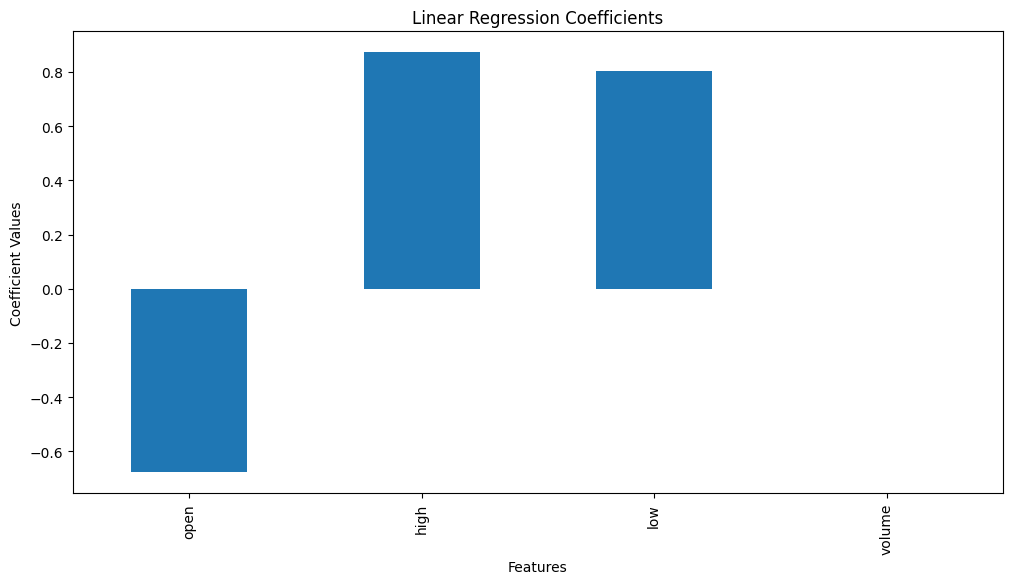

EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9977845563718858
Mean Squared Error MSE: 673006.0311099022
Root Mean Squared Error RMSE: 820.3694479378801
Mean Absolute Error MAE: 518.1355345287592
Mean Absolute Percentage Error MAPE% 1.28% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.995382013661036
Mean Squared Error MSE: 2937059.0575400577
Root Mean Squared Error RMSE: 1713.785009136227
Mean Absolute Error MAE: 1254.468670758624
Mean Absolute Percentage Error MAPE% 1.23%


In [13]:
# Ridge: hyperparameter Tuning (trong lúc đóng gói đã test thử với 'alpha', 'solver', 'random_state' with gird_search)
param_Ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100], # L2 regularization strength
    # 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], # pp giải quyết optimal values
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],  # sparse_cg, saga not support
    'fit_intercept': [True, False], # model có dùng hệ số chặn không.
    'copy_X': [True, False],
    'max_iter': [None, 1000, 5000],
    'tol': [0.001, 0.0001, 0.00001], # độ biến thiên tối thiểu cho phép tiếp tục huấn luyện.
    'positive': [True, False],
    'random_state': [42] # or any other integer value
}
best_ridge_model = LinearRegressionModel(X_train, y_train, Ridge, param_gird_or_dist=param_Ridge, search_type='random_search')
best_ridge_model.print_best_param()
print(best_ridge_model.get_coef_pdSeries())
best_ridge_model.print_important_features()
best_ridge_model.plot_coef_bar()
best_ridge_model.evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e+07, tolerance: 2.901e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.362e+07, tolerance: 1.649e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-p

Best parameters found:  {'alpha': 100, 'random_state': 42}
open      0.273009
high      0.658029
low       0.059890
volume   -0.000037
dtype: float64
Important features: Index(['open', 'high', 'low', 'volume'], dtype='object')


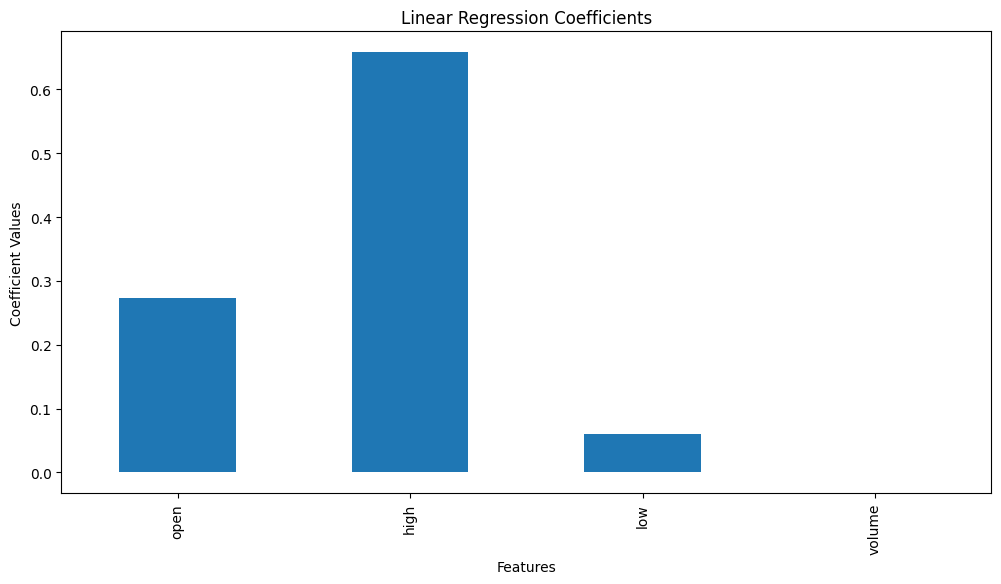

EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9977845563718858
Mean Squared Error MSE: 673006.0311099022
Root Mean Squared Error RMSE: 820.3694479378801
Mean Absolute Error MAE: 518.1355345287592
Mean Absolute Percentage Error MAPE% 1.28% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.995382013661036
Mean Squared Error MSE: 2937059.0575400577
Root Mean Squared Error RMSE: 1713.785009136227
Mean Absolute Error MAE: 1254.468670758624
Mean Absolute Percentage Error MAPE% 1.23%


In [14]:
# Lasso simple training
from sklearn.linear_model import Lasso

param_Lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'random_state': [42] # or any other integer value
}

best_ridge_model = LinearRegressionModel(X_train, y_train, Lasso, param_gird_or_dist=param_Lasso, search_type='grid_search')
best_ridge_model.print_best_param()
print(best_ridge_model.get_coef_pdSeries())
best_ridge_model.print_important_features()
best_ridge_model.plot_coef_bar()
best_ridge_model.evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

Best parameters found:  {'warm_start': True, 'tol': 0.001, 'selection': 'cyclic', 'random_state': 42, 'precompute': False, 'positive': False, 'max_iter': 10000, 'fit_intercept': True, 'copy_X': False, 'alpha': 10}
open     -0.683468
high      0.901388
low       0.778805
volume   -0.000010
dtype: float64
Important features: Index(['open', 'high', 'low', 'volume'], dtype='object')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+08, tolerance: 3.363e+08
  model = cd_fast.enet_coordinate_descent(


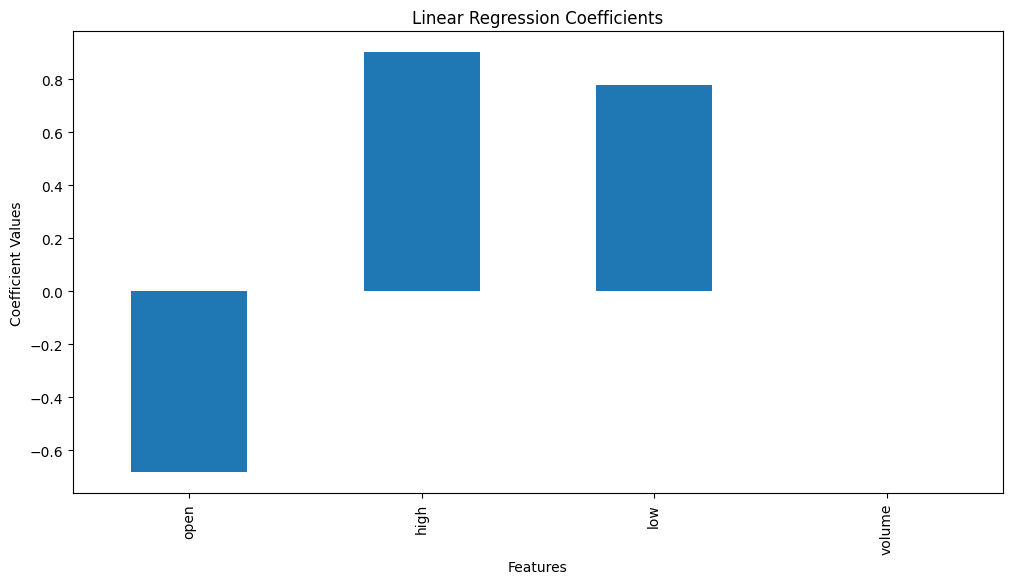

EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9977845563718858
Mean Squared Error MSE: 673006.0311099022
Root Mean Squared Error RMSE: 820.3694479378801
Mean Absolute Error MAE: 518.1355345287592
Mean Absolute Percentage Error MAPE% 1.28% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.995382013661036
Mean Squared Error MSE: 2937059.0575400577
Root Mean Squared Error RMSE: 1713.785009136227
Mean Absolute Error MAE: 1254.468670758624
Mean Absolute Percentage Error MAPE% 1.23%


In [15]:
# Lasso training with many parameters
from sklearn.linear_model import Lasso

param_Lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'precompute': [True, False],
    'copy_X': [True, False],
    'max_iter': [1000, 5000, 10000],
    'tol': [0.0001, 0.001, 0.01, 0.1], # độ biến thiên tối thieru để tiếp tục huẩn luyện model
    'warm_start': [True, False],
    'positive': [True, False],
    'selection': ['cyclic', 'random'],
    'random_state': [42]
}

best_ridge_model = LinearRegressionModel(X_train, y_train, Lasso, param_gird_or_dist=param_Lasso, search_type='random_search')
best_ridge_model.print_best_param()
print(best_ridge_model.get_coef_pdSeries())
best_ridge_model.print_important_features()
best_ridge_model.plot_coef_bar()
best_ridge_model.evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

- Important Features methodology:

To identify important features and improve model performance, we can follow a few methodologies. Experiment with features:

- 1.  Remove features(that are not important or can cause interference).

- 2. Testing feature combinations(combine features together to create new features)

- 3. Consider selecting a different model(if the linear model is not powerful enough for complex relationships between variables).

- 4. Combine important features with other models.

Experiment:
We tested with Lasso Regression and obtained Important features : ['GOLD_open', 'GOLD_low', 'copper', 'crude_oil', 'DXY', 'NLR']

# 4 - Model Evaluation and Best Multiple Linear Regression after Turning



## ***1. Methodology***

### Methodlodogy for Simple Linear Regression

1. Difinition
- Linear Regression methodology:
    - Simple Linear Regression: only 1 independent var Y = b0 + b1*X
    - Multi Linear Regression: More than one independent variable   
    Y = m0 + m1X1 + m2X2 + m3X3 + ... + mNXN
    - Polynomial Regression: independent variable of higher order than 1 (for example, order 2, 3)
- Logistic Reg: Classification Problem. (probability prediction of dependent variable based on independent variables.)

2. How Model works:
- In Linear Regression, we need to find the parameter set m_i (i from 0 to N) so that the function Y = f(X) best fits the training data set.

- The process of finding the model parameter: w0, w1, ..., wn set through the training process can use Gradient Descent, Stochastic Gradient Descent or Normal Equation methods by optimizing the MSE loss function.

MSE (Mean Squared Error) loss function formula```MSE = 1/n * (Yi - Ŷi)^2```
In there:
- Yi is the actual output value of the i-th data point;
- Ŷi is the output value predicted by the model with input Xi;
- n is the number of data points in the training set.

### Methodlodogy for Lasso and Ridge reg

1. Definition:
- Lasso and Ridge Regression are two regularization methods used to reduce overfitting in Linear Regression model.    
    - Lasso uses L1 regularization: to remove unimportant variables completely BY push the coefficients to zero completely.
    - Ridge uses L2 regularization: to remove unimportant variables incompletely BY push the coefficients close to zero, but never down to zero completely.    
- The choice between these two methods depends on THE NUMBER OF FEATURES AND INFLUENCE OF EACH FEATURE.

2. How model work? similar to Linear Regression with loss function.

And the formula for Lasso Regression loss function is:

$$MSE_{Lasso} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 + \alpha \sum_{j=1}^{p} |w_j|$$

The formula for Ridge Regression loss function is:

$$MSE_{Ridge} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 + \alpha \sum_{j=1}^{p} w_j^2$$



- $MSE$ is the mean squared error between the predicted values and the true values.
- $n$ is the number of training samples.
- $p$ is the number of features in the model.
- $y_i$ is the true value of the ith sample.
- $\hat{y_i}$ is the predicted value of the ith sample.
- $w_j$ is the weight corresponding to the jth feature in the model.
- $\alpha$ is the regularization parameter.

### Methodology for Grid Search and Randomized Search:
Grid Search (tìm kiếm theo lưới) and randomized search (tìm kiếm ngẫu nhiên) for hyperparameters tuning:
- are approaches to finding hyperparameters for machine learning models.
- Grid Search:    
    - Make sure to find the best solution.    
    - Easy reproducibility of results.    
    - It takes a lot of computation time when the model has many hyperparameters.
- Randomized Search in reverse. (fits multiple hyperparameters)

## ***2. Model performance:***
- Both Linear Regression, Ridge Reg with the best parameters, Lasso Reg with the best parameters all produce models with almost the same performance.
- The best model we trained was the SIMPLE Ridge regression model when the hyperparameters were simple adjusted: alpha = 0.5, solver='lsqr', the results are below:

| Metrics  | Train Set   | Test Set   |
|----------|-------------|------------|
| R2       | 0.9996      | 0.9991     |
| MSE      | 31.0418     | 31.2566    |
| RMSE     | 5.5715      | 5.5907     |
| MAE      | 3.2427      | 3.6209     |
| MAPE (%) | 0.2175      | 0.2375     |


2. Experiment:
We training with Lasso Regression and obtained Important features as below : ['GOLD_open', 'GOLD_low', 'copper', 'crude_oil', 'DXY', 'NLR'].
We tried training the model with the above input features but the model's performance did not improve much.

## ***3. Run Quickly: ***

In [16]:
# Import Lib
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

In [17]:
# Load and Preprocessing Data

# Load Data
import pandas as pd
# data = pd.read_csv("https://github.com/lavibula/GoldPricePrediction/blob/main/data/data_preparation/data_preparation.csv")
# data = pd.read_csv("https://raw.githubusercontent.com/lavibula/GoldPricePrediction/main/data/data_preparation/data_preparation.csv")
data = pd.read_csv("D:/OneDrive - Hanoi University of Science and Technology/GIT/MiniProj_StockPrediction_ML_SpManhGraduationProj_2024/data/raw20192024/FPT_stock_data.csv")
# Use BTC_close_tomorrow -> y (Target col) of X_today, BTC_close_today -> 1 feature in X_today.
data["close_tomor"] = data["close"].shift(-1)
data = data.iloc[:-1] # data = data.drop(data.index[-1]) # Xóa hàng cuối
data.drop('close', axis=1, inplace=True) # axis=1 xóa cột, =0 xóa hàng, inplace thay đổi trực tiếp trên df hiện tại
data  # 3422 rows × 18 columns -> 17 col

,time,open,high,low,volume,close_tomor
0,2019-01-02,15580.0,15710.0,15330.0,459120,15200.0
1,2019-01-03,15450.0,15450.0,15170.0,716600,15320.0
2,2019-01-04,15130.0,15450.0,15090.0,318570,15580.0
3,2019-01-07,15580.0,15690.0,15500.0,408470,15650.0
4,2019-01-08,15580.0,15650.0,15540.0,295660,15800.0
...,...,...,...,...,...,...
1471,2024-11-21,132400.0,133000.0,131000.0,3176700,133900.0
1472,2024-11-22,132900.0,134400.0,132500.0,2915900,133900.0
1473,2024-11-25,134000.0,134000.0,133200.0,1849700,135200.0
1474,2024-11-26,133400.0,135900.0,133300.0,4176100,138900.0


In [18]:
# Đóng gói def Evaluate_Model and def Plot_Model
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test):
  """
  parameters: `y_test`, `y_pred_test`
  calculates evaluation metrics,
    including R-squared, MSE, RMSE, MAE, MAPE,
      and directional accuracy (DA)
  """
# Đóng gói def Evaluate_Model and def Plot_Model
  print('EVALUATE METRICS ON THE TRAIN SET')
  print('Coefficient of determination R2:', r2_score(y_train, y_pred_train)) # print(model.score(X_test, y_train))
  print('Mean Squared Error MSE:', mean_squared_error(y_train, y_pred_train))
  print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
  print('Mean Absolute Error MAE:', mean_absolute_error(y_train, y_pred_train))
  MAPE = mean_absolute_percentage_error(y_train, y_pred_train)
  # MAPE = np.mean(np.abs((np.array(y_train) - np.array(y_pred_train)) / y_train))
  print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 4)}%", '\n')

  print('EVALUATE METRICS ON THE TEST SET')
  print('Coefficient of determination R2:', r2_score(y_test, y_pred_test)) # print(model.score(X_test, y_test))
  print('Mean Squared Error MSE:', mean_squared_error(y_test, y_pred_test))
  print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
  print('Mean Absolute Error MAE:', mean_absolute_error(y_test, y_pred_test))
  MAPE = mean_absolute_percentage_error(y_test, y_pred_test)
  # MAPE = np.mean(np.abs((np.array(y_test) - np.array(y_pred_test)) / y_test))
  print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 4)}%")

def Plot_Model(y_test, y_pred_test, num_samples):
  """
  Scatter Plot(Biểu đồ phân tán) with x_axis: y_test, y_axis: y_pred_test
  Print test_pred_df
  Line Plot with x_axis: position point, y_axis: Value and 2 line: y_test, y_pred_test
  """
  # Gộp 2 Plot scatterplot and lineplot
  plt.subplots(figsize=(15,7)) # return tuple (Figure, Axes). obj Figure: toàn bộ hình ảnh, obj Axes: các vùng trực quan.
  ax1 = plt.subplot(121)
  ax2 = plt.subplot(122)

  # Scatter plot
  ax1.scatter(y_test, y_pred_test)
  ax1.set_title("Predictions vs Actual")  #plt.title
  ax1.set_xlabel("y_true")                #plt.xlabel
  ax1.set_ylabel("y_pred_test")           #plt.ylabel

  x = range(int(max(y_test))) #vẽ đường chéo giữa.
                              # type y_test from df: <class 'pandas.core.series.Series'>, tương tự df, but have only 1 col
  ax1.plot(x, 'r') # Opt speed, we can use x = np.arange(int(max(y_test))).astype(int)

  # Line plot with x_axis: position point, y_axis: Value and 2 line: y_test, y_pred_test
  #1 plot vẽ tập Test nhưng show ra x 6000 điểm -> vì plot ra index của hàng ban đầu.
  #2 Muốn plot ra tập sample với ít điểm giá trị hơn.
  #3 Muốn plot hiện điểm 1, 2, 3, ... chứ không phải điểm 0.0, 0.5, 1.0, ...
  test_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test}) # Create df 3 col: index, y_test, y_pred_test
  test_pred_subset_df = pd.DataFrame({'y_test_few': y_test[:num_samples], 'y_pred_test_few': y_pred_test[:num_samples]}) #2
  test_pred_subset_df = test_pred_subset_df.reset_index(drop=True) #1 Add a reset index and Remove old index

  # sns.lineplot(data=test_pred_subset_df) # data = df
  sns.lineplot(data=test_pred_subset_df).set(xticks=range(0, num_samples+1, int(num_samples/5)+1))
                                        # set x_axis ticks (dấu kiểm) hiện ít điểm hơn trên x
  ax2.set_title("Test Predictions")
  ax2.set_xlabel("Point") # tên hàng
  ax2.set_ylabel("Value")
  plt.show() # show những plots above

# y_train = [10 , 15, 20, 25, 30, 35, 40]
# y_pred_train = [-10, -15, -20, -25, -30, -35, -40]

# y_test = [10 , 15, 20, 25, 30, 35, 40]
# y_pred_test = [-10, -15, -20, -25, -30, -35, -40]
# Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test)
# Plot_Model(y_test, y_pred_test, 6)

In [19]:
# Split data for pre-train
X = data.drop(['close_tomor', 'time'], axis=1)
y = data['close_tomor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle = False) # shuffle: default: True, False sẽ giúp dùn qk để train và dự báo cho tương lai.


EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9977797155743999
Mean Squared Error MSE: 674476.5654363135
Root Mean Squared Error RMSE: 821.2652223467845
Mean Absolute Error MAE: 518.185109464765
Mean Absolute Percentage Error MAPE% 1.2845% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.995302257226857
Mean Squared Error MSE: 2987784.490706912
Root Mean Squared Error RMSE: 1728.5208968094403
Mean Absolute Error MAE: 1267.4393457168815
Mean Absolute Percentage Error MAPE% 1.2371%


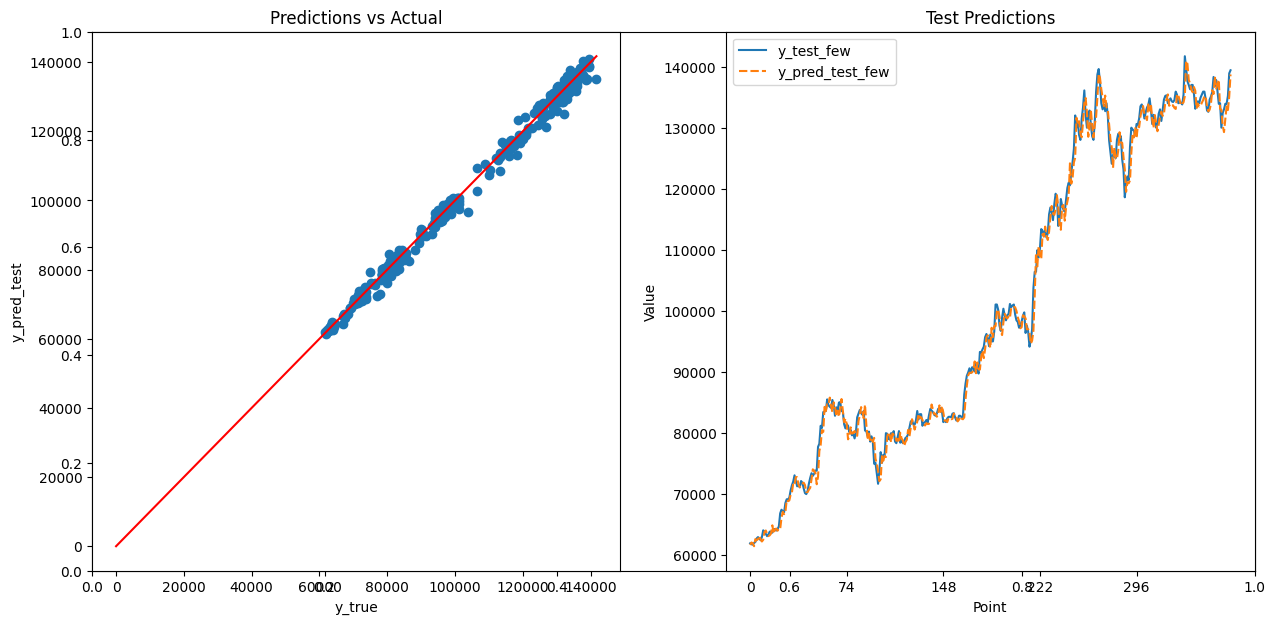

In [21]:
# Best Tuning Model - SIMPLE Ridge Regression when hyperparameters have not been adjusted
from sklearn.linear_model import Ridge

X = data.drop(['close_tomor', 'time'], axis=1)
y = data['close_tomor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle = False) # shuffle: default: True, False sẽ giúp dùn qk để train và dự báo cho tương lai.

ridge_model = Ridge(alpha = 0.5, solver='lsqr') # lsqr: tối ưu
ridge_model.fit(X_train, y_train)

y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_test_ridge = ridge_model.predict(X_test)

Evaluate_Model(y_train, y_pred_train_ridge, y_test, y_pred_test_ridge)
Plot_Model(y_test, y_pred_test_ridge, len(y_test))

| Metrics  | Train Set   | Test Set   |
|----------|-------------|------------|
| R2       | 0.9978      | 0.9953     |
| MSE      | 674476.57   | 2987784.49 |
| RMSE     | 821.27      | 1728.52    |
| MAE      | 518.19      | 1267.44    |
| MAPE (%) | 1.2845      | 1.2371     |